# Synthetic Sonic Log Generation -- Yanxiang Yu 

* __Author__: _Yanxiang Yu_
* __Date__: February 26th, 2020


- <a>1. Introduction: Synthetic Sonic Curves Generation </a>
    - <a>1.1. Background</a>
    - <a>1.2. Problem Statement</a>
    - <a>1.3. Data Description</a>
    - <a>1.4. Evaluation Metric</a>
- <a>2. Imports</a>
- <a>3. Read in Data</a>
- <a>4. Glimpse of Data</a>
- <a>5. Exploratory Data Analysis</a>
- <a>6. Build Machine Models</a>
- <a>7. Prediction</a>
- <a>8. Summary</a>

<a></a>

## <a>1. Introduction: Synthetic Sonic Curves Generation</a>


### <a>1.1. Background</a>
Well logs are interpreted/processed to estimate the in-situ petrophysical and geomechanical properties, which is essential for subsurface characterization. Various types of logs exist, and each provides distinct information about subsurface properties. Certain well logs, like gamma ray (GR), resistivity, density, and neutron logs, are considered as “easy-to-acquire” conventional well logs that are run in most of the wells. Other well logs, like nuclear magnetic resonance, dielectric dispersion, elemental spectroscopy, and sometimes sonic logs, are only run in limited number of wells.

Sonic travel-time logs contain critical geomechanical information for subsurface characterization around the wellbore. Often, sonic logs are required to complete the well-seismic tie workflow or geomechanical properties prediction. When sonic logs are absent in a well or an interval, a common practice is to synthesize them based on its neighboring wells that have sonic logs. This is referred to as sonic log synthesis or pseudo sonic log generation.


### <a>1.2. Problem Statement</a>
Compressional travel-time (DTC) and shear travel-time (DTS) logs are not acquired in all the wells drilled in a field due to financial or operational constraints. Under such circumstances, machine learning techniques can be used to predict DTC and DTS logs to improve subsurface characterization. The goal of the “SPWLA’s 1st Petrophysical Data-Driven Analytics Contest” is to develop data-driven models by processing “easy-to-acquire” conventional logs from Well #1, and use the data-driven models to generate synthetic compressional and shear travel-time logs (DTC and DTS, respectively) in Well #2. A robust data-driven model for the desired sonic-log synthesis will result in low prediction errors, which can be quantified in terms of Root Mean Squared Error by comparing the synthesized and the original DTC and DTS logs.

You are provided with two datasets: train.csv and test.csv. You need to build a generalizable data-driven models using train dataset. Following that, you will deploy the newly developed data-driven models on test dataset to predict DTS and DTC logs. The data-driven model should use feature sets derived from the following 7 logs: Caliper, Neutron, Gamma Ray, Deep Resistivity, Medium Resistivity, Photo-electric factor and density. The data-driven model should synthesize two target logs: DTC and DTS logs.

The predicted values should be in the same format as sample_submission.csv, and submit together with your notebook for evaluation. 

### <a>1.3. Data Decription</a>
#### Files
&gt; #### train.csv
All the values equals to -999 are marked as missing values.
- CAL - Caliper, unit in Inch,  
- CNC - Neutron, unit in dec 
- GR - Gamma Ray, unit in API
- HRD - Deep Resisitivity, unit in Ohm per meter,
- HRM - Medium Resistivity, unit in Ohm per meter,
- PE - Photo-electric Factor, unit in Barn,
- ZDEN - Density, unit in Gram per cubit meter, 
- DTC - Compressional Travel-time, unit in nanosecond per foot,
- DTS - Shear Travel-time, unit in nanosecond per foot,


&gt; #### test.csv
The test data has all features that you used in the train dataset, except the two sonic curves DTC and DTS.

&gt; ####  sample_submission.csv
A valid sample submission.
<p><font style="">
</font></p>

### <a>1.4. Evaluation Metric</a>
We will be evaluated by the metirc `Root Mean Squared Error`.

The RMSE is calculated as:

$ ϵ=∑_i \sqrt{ ∑_n (y_p - y_t)^2 /n } $

Where:
- y_p is the predicted curve for DTC and DTS
- y_t is the true value for evaluation.

DTC and DTS are in the same weight during the evaluation 

Understanding and optimizing your predictions for this evaluation metric is paramount for this compeition.

## <a>2. Imports</a>

<a>Top</a>

In [1]:
# import libraries
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb
# import sklearn libararies
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression 
from sklearn.neural_network import MLPRegressor

In [2]:
!pip install tensorflow==2.0.0

In [3]:
!pip install keras

## <a>3. Read Data</a>

<a>Top</a>

In [4]:
df1 = pd.read_csv('train.csv')


## <a>4. Glimps Data</a>

<a>Top</a>

In [5]:
df1.describe()

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC,DTS
count,30143.000000,30143.000000,30143.000000,30143.000000,30143.000000,30143.000000,30143.000000,30143.000000,30143.000000
mean,-8.394576,-23.692615,38.959845,3.977690,1.547299,-17.446739,-20.229982,-54.891703,-9.737567
std,129.970219,157.142679,108.504554,365.112753,456.908969,149.083136,148.809506,372.858812,440.314119
min,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000
25%,8.058350,0.122800,17.248750,0.717700,0.712050,0.053100,2.226700,66.304350,118.534350
50%,8.625000,0.193600,36.821800,1.623000,1.628100,4.941500,2.432200,78.355100,137.689300
75%,9.048850,0.337150,58.346150,3.158300,3.280600,7.856650,2.551350,107.022500,182.973150
max,21.064200,3490.158200,1470.253400,10000.000000,60467.761700,28.106400,3.259700,155.980300,487.438400


## <a>5. Exploratory Data Analysis</a>

<a>Top</a>

Exploratory Data Analysis (EDA) is an open-ended process where we calculate statistics and make figures to find trends, missing values, outliers, anomalies, patterns, or relationships within the data. 

In [6]:
# remove all rows that contains missing value
df1.replace(['-999', -999], np.nan, inplace=True)
df1.dropna(axis=0, inplace=True)
df1.describe()

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC,DTS
count,20525.000000,20525.000000,20525.000000,20525.000000,20525.000000,20525.000000,20525.000000,20525.000000,20525.000000
mean,8.426679,0.274416,49.889253,2.598719,5.835466,3.833792,2.410734,88.312221,182.051067
std,1.845912,3.062495,54.811017,3.465665,422.449589,4.375818,0.181713,23.542419,84.670122
min,5.930400,0.014500,1.038900,0.123600,0.134100,-0.023200,0.680600,49.970500,80.580400
25%,6.629100,0.120300,16.036800,0.810000,0.797300,0.049800,2.236100,70.423100,127.148800
50%,8.578100,0.187700,37.498000,1.814900,1.829300,3.287800,2.466500,79.695400,142.678500
75%,8.671900,0.329000,61.140700,3.337400,3.463300,7.061300,2.563700,102.482800,192.757800
max,21.064200,365.885000,1470.253400,206.718200,60467.761700,28.106400,3.259700,155.980300,487.438400


In [7]:
df1.columns.tolist()

['CAL', 'CNC', 'GR', 'HRD', 'HRM', 'PE', 'ZDEN', 'DTC', 'DTS']

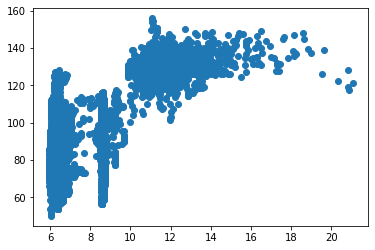

In [8]:
# check if there's any co-linearity between features
# you may check this for all of the features and see if there's any good finding. 
plt.scatter(df1['CAL'], df1['DTC'])

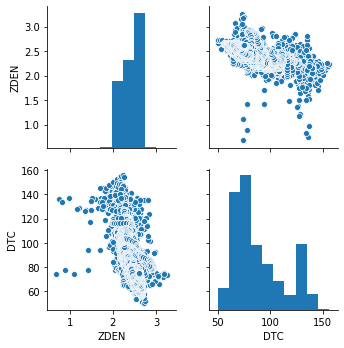

In [9]:
# another library from Seaborn to check the co-linearity
sb.pairplot(df1[['ZDEN', 'DTC']])

## <a>6. Build Machine Learning Models</a>

<a>Top</a>

In [10]:
# seperate the features and targets
df1_data = np.array(df1)
y_trainwell1 = df1_data[:,-2:]
x_trainwell1 = df1_data[:,:-2]

# standize the matrix for training data
scaler = StandardScaler()
x_trainwell1 = scaler.fit_transform(x_trainwell1)

In [11]:
print(y_trainwell1[:5][:])

[[125.9611 306.8676]
 [125.9726 305.8347]
 [125.8528 305.9089]
 [125.7362 305.1737]
 [125.9774 304.4476]]


In [12]:
np.shape(y_trainwell1)

(20525, 2)

In [13]:
# train test split
# please remember to use random_state for all randomization steps, this will ensure we get the same results 
# as yours during the validation phase. 
X_train, X_test, y_train, y_test = train_test_split(x_trainwell1, y_trainwell1, test_size=0.2, random_state=100)


In [14]:
def grid_search(clf, param_grid, X_train=X_train, y_train=y_train):
    """
    Fits a classifier to its training data and prints its ROC AUC score.
    
    INPUT:
    - clf (classifier): classifier to fit
    - param_grid (dict): classifier parameters used with GridSearchCV
    - X_train (DataFrame): training input
    - y_train (DataFrame): training output
            
    OUTPUT:
    - classifier: input classifier fitted to the training data
    """
    # cv uses StratifiedKFold
    # scoring r2 as parameter
    grid = GridSearchCV(estimator=clf, 
                        param_grid=param_grid, 
                        scoring='r2', 
                        cv=5)
    grid.fit(X_train, y_train)
    print(grid.best_score_)
    
    return grid.best_estimator_

In [15]:
def result_plot(y_predict, y_real=y_trainwell1):
    # check the accuracy of predicted data and plot the result
    print('Root Mean Square Error is:', '{:.5f}'.format(np.sqrt(mean_squared_error(y_real, y_predict))))
    plt.subplots(nrows=2, ncols=2, figsize=(16,10))
    plt.subplot(2, 2, 1)
    plt.plot(y_real[:, 0])
    plt.plot(y_predict[:, 0])
    plt.legend(['True', 'Predicted'])
    plt.xlabel('Sample')
    plt.ylabel('DTC')
    plt.title('DTC Prediction Comparison')

    plt.subplot(2, 2, 2)
    plt.plot(y_real[:, 1])
    plt.plot(y_predict[:, 1])
    plt.legend(['True', 'Predicted'])
    plt.xlabel('Sample')
    plt.ylabel('DTS')
    plt.title('DTS Prediction Comparison')
    
    plt.subplot(2, 2, 3)
    plt.scatter(y_real[:, 0], y_predict[:, 0])
    plt.xlabel('Real Value')
    plt.ylabel('Predicted Value')
    plt.title('DTC Prediction Comparison')
    
    plt.subplot(2, 2, 4)
    plt.scatter(y_real[:, 1], y_predict[:, 1])
    plt.xlabel('Real Value')
    plt.ylabel('Predicted Value')
    plt.title('DTS Prediction Comparison')

    plt.show()

0.710174709687991
Root Mean Square Error is: 21.99087


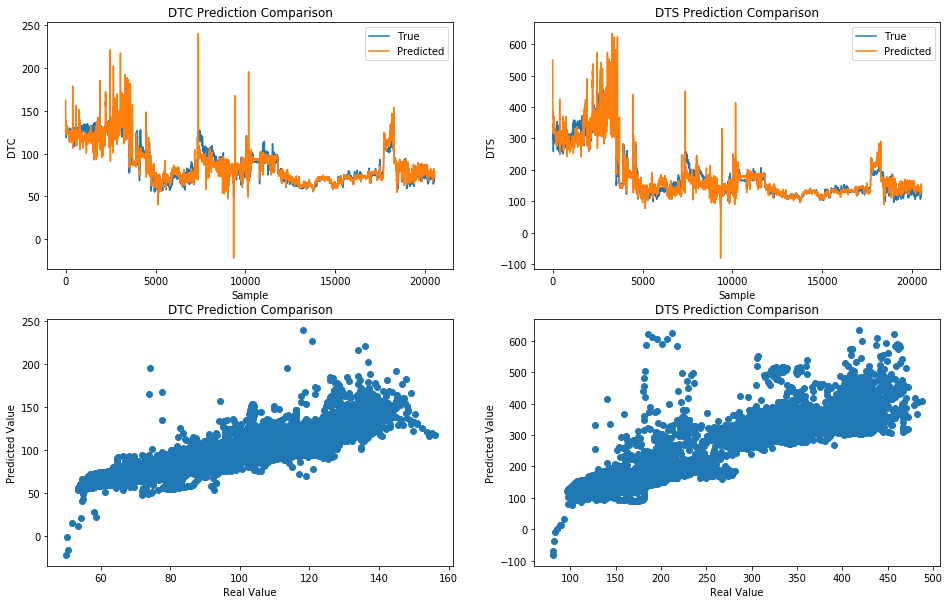

In [16]:
# Linear regression model as the baseline
LR = LinearRegression()
LR_best = grid_search(LR, {})
LR_predict = LR_best.predict(x_trainwell1)
result_plot(LR_predict, y_trainwell1)

C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the buil

Accuracy Score is: 0.87412
Root Mean Square Error is: 21.99087


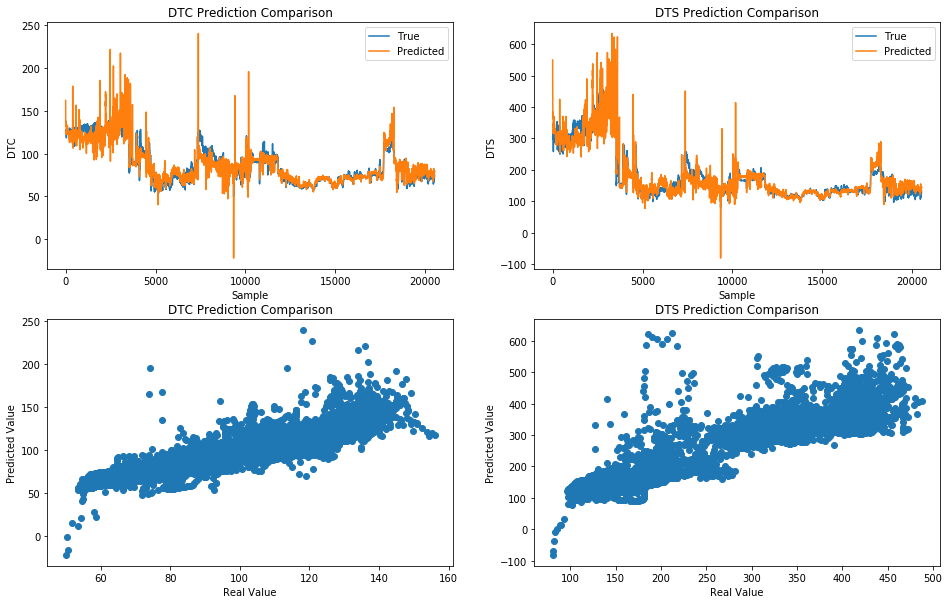

In [18]:
# Add ridge regularization, and see if there's any improvement
ridge = RidgeCV(cv=5, alphas=[1e-3, 1e-2, 1e-1, 1], )
ridge.fit(X_train, y_train)
print('Accuracy Score is:', '{:.5f}'.format(ridge.score(X_train, y_train)))
result_plot(ridge.predict(x_trainwell1), y_trainwell1)

0.9875374190713717
Root Mean Square Error is: 3.27980


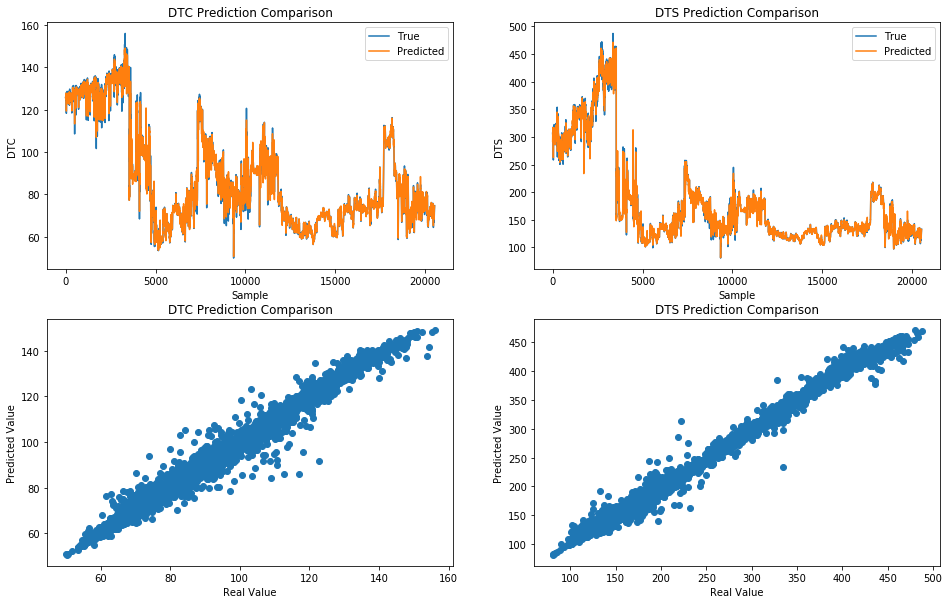

In [19]:
# Random forest model
RF = RandomForestRegressor(n_estimators=100, random_state=100)
RF_best = grid_search(RF, {})
result_plot(RF_best.predict(x_trainwell1), y_trainwell1)

Root Mean Square Error is: 5.76639


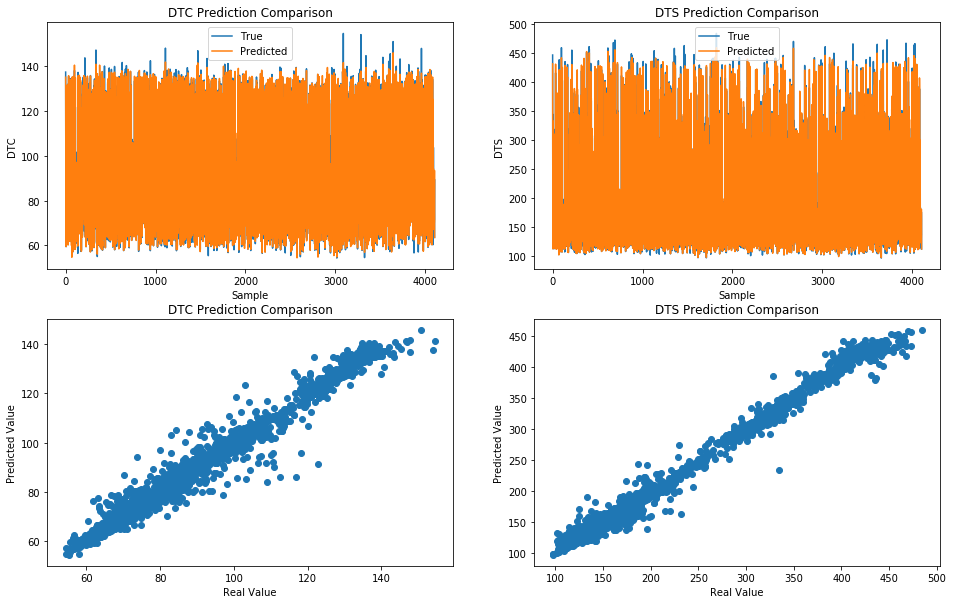

In [20]:
# check the result on test dataset only
result_plot(RF_best.predict(X_test), y_test)

## Deep Learning 

In [21]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from keras.callbacks import EarlyStopping

import seaborn as sb

import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

Using TensorFlow backend.


### It is important to keep the time sequential information for RNN, so the train test data needs to be resplitted.

In [24]:
# Split train-dev and test sets
test_fraction = 0.20
X_train_norm, X_test_norm, y_train_norm, y_test_norm = train_test_split(x_trainwell1,
                                                  y_trainwell1,
                                                  test_size=test_fraction,
                                                  shuffle=False)

In [23]:
data_train_norm = np.concatenate((X_train_norm,y_train_norm),axis = 1)
data_test_norm = np.concatenate((X_test_norm, y_test_norm),axis = 1)

In [25]:
X_train_norm.shape

(16420, 7)

In [42]:
len(data_train_norm)

16420

In [43]:
len(data_test_norm)

4105

## Reshape data as multivariate input

In [26]:
def multivariate_data(dataset, target, start_index, end_index, history_size,target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
    
    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])
        
    if single_step:
        labels.append(target[i+target_size])
    else:
        labels.append(target[i:i+target_size])
    
    return np.array(data), np.array(labels)

In [27]:
# Create time blocks
past_history = 40
future_target = 0   # predict current. use 'past_history' points
STEP = 1

x_train_single, y_train_single = multivariate_data(X_train_norm, y_train_norm, 0,
                                                   None, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_test_single, y_test_single = multivariate_data(X_test_norm, y_test_norm,
                                               0, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [46]:
# Create time blocks
past_history = 40
future_target = 0   # predict current. use 'past_history' points
STEP = 1

x_train_single, y_train_single = multivariate_data(data_train_norm, y_train_norm, 0,
                                                   None, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_test_single, y_test_single = multivariate_data(data_test_norm, y_test_norm,
                                               0, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [34]:
# Every "looK_back" X points, only one Y, does not predict future. 
def reshape_data(X, Y, look_back=1):
    dataX, dataY = [], []
    for i in range(len(X) - look_back):
        a = X[i:(i + look_back), :]
        dataX.append(a)
        dataY.append(Y[i + look_back, :])
    print('# of data: ', len(dataY))
    return np.array(dataX), np.array(dataY)

In [35]:
# Create time blocks
x_train, y_train = reshape_data(X_train_norm, y_train_norm, look_back=40)
x_test, y_test = reshape_data(X_test_norm, y_test_norm, look_back=40)

# of data:  16380
# of data:  4065


In [30]:
X_train_norm

array([[ 3.4973928 ,  0.07931108,  0.13320726, ..., -0.00914419,
         5.50982555, -0.32873472],
       [ 3.53780741,  0.07255172,  0.24211137, ..., -0.00993791,
         5.54712234, -0.02880465],
       [ 3.36287606,  0.05514718,  0.2669683 , ..., -0.01029465,
         5.20212704,  0.25956847],
       ...,
       [ 0.12011781, -0.03830832,  0.01100622, ..., -0.00797527,
        -0.86449754,  0.73670493],
       [ 0.10744084, -0.03896139, -0.02720601, ..., -0.00780483,
        -0.8652517 ,  0.75376517],
       [ 0.10744084, -0.03954916, -0.05674094, ..., -0.00723575,
        -0.8655945 ,  0.78458367]])

In [54]:
x_trainwell2

array([[ 0.08203273,  0.02536682,  0.09657322, ..., -0.01196495,
         0.68453048, -0.46851864],
       [ 0.08203273,  0.02921998,  0.12994323, ..., -0.01198555,
         0.68016548, -0.46906897],
       [ 0.08203273,  0.03130983,  0.16488049, ..., -0.01214533,
         0.67253243, -0.49273318],
       ...,
       [ 0.16248273, -0.03004688,  0.34596711, ..., -0.01139943,
         0.57305147,  0.12914017],
       [ 0.1751597 , -0.03011218,  0.38245519, ..., -0.01131847,
         0.54656435,  0.1170329 ],
       [ 0.1751597 , -0.02952441,  0.36529399, ..., -0.0113393 ,
         0.52464792,  0.11318059]])

In [55]:
len(x_trainwell2)

11088

In [56]:
# Every "looK_back" X points, only one Y, does not predict future. 
def reshape_data1(X, look_back=1):
    dataX = []
    for i in range(len(X) - look_back):
        a = X[i:(i + look_back), :]
        dataX.append(a)
        
    print('# of data: ', len(dataX))
    return np.array(dataX)
x_test = reshape_data1(x_trainwell2, look_back=40)

# of data:  11048


In [32]:
# Create time blocks
x_train, y_train = reshape_data(X_train_norm, y_train_norm, look_back=40)
x_test, y_test = reshape_data(y_test_norm, y_test_norm, look_back=40)

# of data:  16380
# of data:  4065


In [36]:
X_train.shape

(16420, 7)

### Let's look at a single data-point. This is important for RNN time series

In [58]:
data_train_norm.shape

NameError: name 'data_train_norm' is not defined

In [37]:
x_train.shape

(16380, 40, 7)

In [38]:
x_test.shape

(4065, 40, 7)

In [39]:
y_test.shape

(4065, 2)

In [40]:
y_train.shape

(16380, 2)

In [41]:
import tensorflow as tf
BATCH_SIZE = 200
BUFFER_SIZE = 500
train_data_single = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

test_data_single = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_data_single = test_data_single.batch(BATCH_SIZE).repeat()

In [54]:
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.layers.recurrent import LSTM, GRU, SimpleRNN
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten, TimeDistributed, Reshape

def run_model(x_train, y_train, x_test, y_test, epochs=500, batch_size=3000, method='LSTM'):
    classifier = {'LSTM' : LSTM}

    inputs = Input(shape=(x_train.shape[1], x_train.shape[2]))

    X = classifier[method](128, return_sequences=True)(inputs)    
    # equvilent to X=LSTM(512, return_sequences=True)(inputs)   
    X = classifier[method](128, return_sequences=True)(X)
    
    X = TimeDistributed(Dense(64, activation='relu'))(X)
    # TimeDistrituted allows you to apply that Dense function across every output at same time
    # 2 outputs in current case
    # 2 results at the same time, hence 2 outputs, not 2 nodes. 
    X = Dropout(0.2)(X)
    
    out1 = Dense(1)(Flatten()(X)) # three well flow rates
    out2 = Dense(1)(Flatten()(X))
  
    
    model = Model(input=inputs, output=[out1, out2])
    
    #parallel_model = multi_gpu_model(model, gpus=8)

    model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(), metrics=['acc'])
    checkpointer = ModelCheckpoint(filepath='RNNweights.hdf5', verbose=1, save_best_only=True)

    history = model.fit(x_train, [y_train[:, 0], y_train[:, 1]], 
                        epochs=epochs, batch_size=batch_size,
                        validation_data=(x_test, [y_test[:, 0], y_test[:, 1]]), 
                        verbose=1, shuffle=True,callbacks=[checkpointer])
    return model, history

In [55]:
model_LSTM, history_LSTM = run_model(x_train, y_train, x_test, y_test, epochs=50, batch_size=3000, method='LSTM')

Train on 16380 samples, validate on 4065 samples
Epoch 1/50
 3000/16380 [====>.........................] - ETA: 25s - loss: 53953.4688 - dense_5_loss: 8670.5059 - dense_6_loss: 45282.9648 - dense_5_acc: 0.0000e+00 - dense_6_acc: 0.0000e+00

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3325, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-55-dd19e4ac9d01>", line 1, in <module>
    model_LSTM, history_LSTM = run_model(x_train, y_train, x_test, y_test, epochs=50, batch_size=3000, method='LSTM')
  File "<ipython-input-54-b70f36c98ffd>", line 35, in run_model
    verbose=1, shuffle=True,callbacks=[checkpointer])
  File "C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\engine\training.py", line 1239, in fit
    validation_freq=validation_freq)
  File "C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\engine\training_arrays.py", line 196, in fit_loop
    outs = fit_function(ins_batch)
  File "C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow_core\python\keras\backend.py", line 3740, in __call__
    o

KeyboardInterrupt: 

In [34]:
# Test
y_pred_test_pre = model_LSTM.predict(x_test)
y_pred_test = np.concatenate((y_pred_test_pre[0], y_pred_test_pre[1]), axis=1)

In [35]:
y_pred_test

array([[ 73.360146, 139.67838 ],
       [ 73.45367 , 139.8056  ],
       [ 73.62007 , 139.97183 ],
       ...,
       [ 86.22466 , 169.74115 ],
       [ 87.079834, 171.0905  ],
       [ 87.81753 , 172.25436 ]], dtype=float32)

R2: 0.1651
Root Mean Square Error is: 22.56078


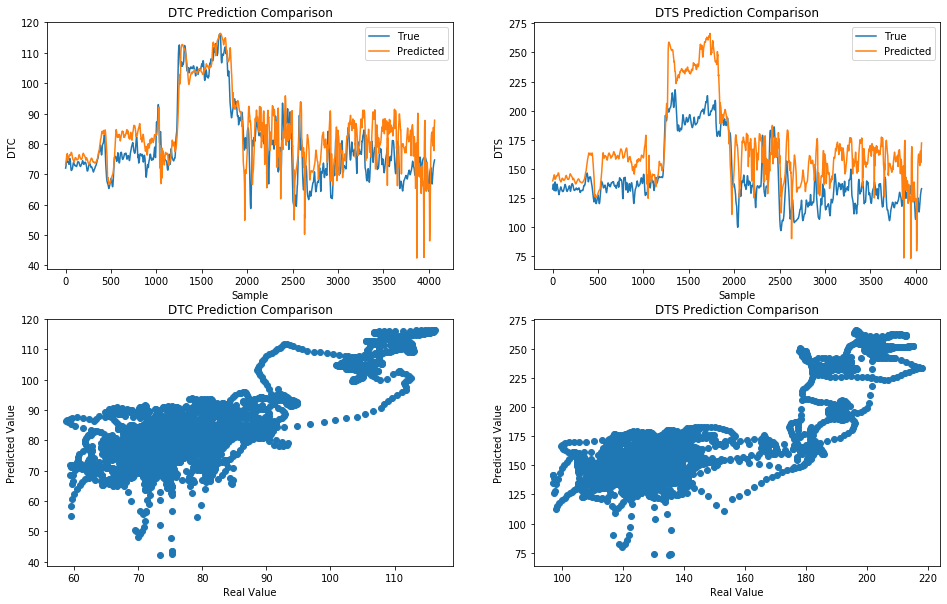

In [36]:
from sklearn import metrics
R2=format(metrics.r2_score(y_test, y_pred_test),'.4f')   
print('R2:',  R2)
result_plot(y_pred_test,y_test)

In [45]:
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.layers.recurrent import LSTM, GRU, SimpleRNN
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten, TimeDistributed, Reshape

def run_model(x_train, y_train, x_test, y_test, epochs=500, batch_size=2000, method='LSTM'):
    classifier = {'LSTM' : LSTM}

    inputs = Input(shape=(x_train.shape[1], x_train.shape[2]))

    X = classifier[method](256, return_sequences=True)(inputs)    
    # equvilent to X=LSTM(512, return_sequences=True)(inputs)   
    X = classifier[method](256, return_sequences=True)(X)
    
    X = TimeDistributed(Dense(128, activation='relu'))(X)
    # TimeDistrituted allows you to apply that Dense function across every output at same time
    # 2 outputs in current case
    # 2 results at the same time, hence 2 outputs, not 2 nodes. 
    X = Dropout(0.2)(X)
    
    out1 = Dense(1)(Flatten()(X)) # three well flow rates
    out2 = Dense(1)(Flatten()(X))
  
    
    model = Model(input=inputs, output=[out1, out2])
    
    #parallel_model = multi_gpu_model(model, gpus=8)

    model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(), metrics=['acc'])
    checkpointer = ModelCheckpoint(filepath='RNNweights.hdf5', verbose=1, save_best_only=True)

    history = model.fit(x_train, [y_train[:, 0], y_train[:, 1]], 
                        epochs=epochs, batch_size=batch_size,
                        validation_data=(x_test, [y_test[:, 0], y_test[:, 1]]), 
                        verbose=1, shuffle=True,callbacks=[checkpointer])
    return model, history

In [53]:
model_LSTM, history_LSTM = run_model(x_train, y_train, x_test, y_test, epochs=100, batch_size=2000, method='LSTM')

Train on 16380 samples, validate on 4065 samples
Epoch 1/100
16380/16380 [==============================] - 51s 3ms/step - loss: 51128.7433 - dense_5_loss: 7907.5859 - dense_6_loss: 42267.9258 - dense_5_acc: 0.0000e+00 - dense_6_acc: 0.0000e+00 - val_loss: 23006.0754 - val_dense_5_loss: 4801.8794 - val_dense_6_loss: 16624.6270 - val_dense_5_acc: 0.0000e+00 - val_dense_6_acc: 0.0000e+00

Epoch 00001: val_loss improved from inf to 23006.07537, saving model to RNNweights.hdf5
Epoch 2/100
16380/16380 [==============================] - 58s 4ms/step - loss: 23061.0245 - dense_5_loss: 2300.1294 - dense_6_loss: 19640.9180 - dense_5_acc: 0.0000e+00 - dense_6_acc: 0.0000e+00 - val_loss: 2670.3664 - val_dense_5_loss: 1884.2036 - val_dense_6_loss: 870.6189 - val_dense_5_acc: 0.0000e+00 - val_dense_6_acc: 0.0000e+00

Epoch 00002: val_loss improved from 23006.07537 to 2670.36638, saving model to RNNweights.hdf5
Epoch 3/100
16380/16380 [==============================] - 60s 4ms/step - loss: 8965.7555

16380/16380 [==============================] - 60s 4ms/step - loss: 395.6304 - dense_5_loss: 42.6969 - dense_6_loss: 350.2329 - dense_5_acc: 0.0000e+00 - dense_6_acc: 0.0000e+00 - val_loss: 2752.3209 - val_dense_5_loss: 265.7946 - val_dense_6_loss: 2226.4956 - val_dense_5_acc: 0.0000e+00 - val_dense_6_acc: 0.0000e+00

Epoch 00042: val_loss did not improve from 1369.34578
Epoch 43/100
16380/16380 [==============================] - 60s 4ms/step - loss: 376.8403 - dense_5_loss: 42.7044 - dense_6_loss: 349.1267 - dense_5_acc: 0.0000e+00 - dense_6_acc: 0.0000e+00 - val_loss: 2550.0067 - val_dense_5_loss: 224.3440 - val_dense_6_loss: 1997.3583 - val_dense_5_acc: 0.0000e+00 - val_dense_6_acc: 0.0000e+00

Epoch 00043: val_loss did not improve from 1369.34578
Epoch 44/100
16380/16380 [==============================] - 61s 4ms/step - loss: 365.5135 - dense_5_loss: 41.1812 - dense_6_loss: 320.3308 - dense_5_acc: 0.0000e+00 - dense_6_acc: 0.0000e+00 - val_loss: 2725.2118 - val_dense_5_loss: 258.12

16380/16380 [==============================] - 67s 4ms/step - loss: 182.4528 - dense_5_loss: 25.8004 - dense_6_loss: 153.4250 - dense_5_acc: 0.0000e+00 - dense_6_acc: 0.0000e+00 - val_loss: 2662.4379 - val_dense_5_loss: 200.2504 - val_dense_6_loss: 2200.2834 - val_dense_5_acc: 0.0000e+00 - val_dense_6_acc: 0.0000e+00

Epoch 00084: val_loss did not improve from 1369.34578
Epoch 85/100
16380/16380 [==============================] - 68s 4ms/step - loss: 177.0189 - dense_5_loss: 25.0877 - dense_6_loss: 153.8177 - dense_5_acc: 0.0000e+00 - dense_6_acc: 0.0000e+00 - val_loss: 2844.0294 - val_dense_5_loss: 217.6106 - val_dense_6_loss: 2319.9143 - val_dense_5_acc: 0.0000e+00 - val_dense_6_acc: 0.0000e+00

Epoch 00085: val_loss did not improve from 1369.34578
Epoch 86/100
16380/16380 [==============================] - 69s 4ms/step - loss: 169.9306 - dense_5_loss: 24.1747 - dense_6_loss: 144.9028 - dense_5_acc: 6.1050e-05 - dense_6_acc: 0.0000e+00 - val_loss: 2680.2482 - val_dense_5_loss: 209.82

In [54]:
# Test
y_pred_test_pre = model_LSTM.predict(x_test)
y_pred_test = np.concatenate((y_pred_test_pre[0], y_pred_test_pre[1]), axis=1)

R2: -1.5211
Root Mean Square Error is: 37.83624


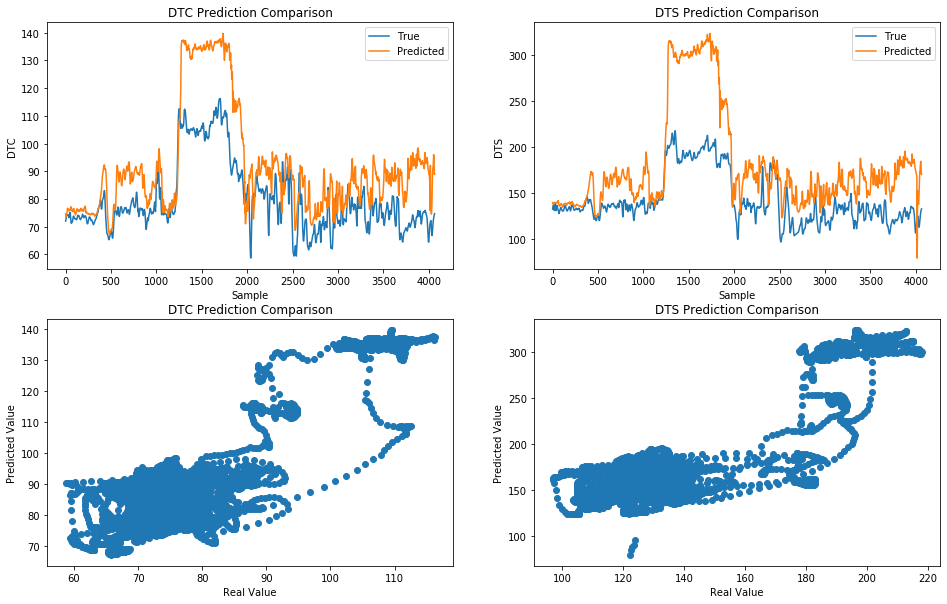

In [55]:
from sklearn import metrics
R2=format(metrics.r2_score(y_test, y_pred_test),'.4f')   
print('R2:',  R2)
result_plot(y_pred_test,y_test)

## CNN + LSTM

In [42]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, LSTM 
from keras import optimizers

In [46]:
def run_cnn_lstm_model(x_train, y_train, x_test, y_test, epochs=500, batch_size=2000):
    
    inputs = Input(shape=(x_train.shape[1], x_train.shape[2]))
    
    X = Conv1D(128, 5, activation='relu',padding='same')(inputs)
    X = Conv1D(128, 5, activation='relu',padding='same')(X)
    
    X_p = MaxPooling1D((3),padding='same')(X)
    
    X_1 = Conv1D(256, 5, activation='relu',padding='same')(X_p)
    X_1 = Conv1D(256, 5, activation='relu',padding='same')(X_1)
    
    X_p1 = MaxPooling1D((3),padding='same')(X_1)
    
    X_LSTM = LSTM(256, activation='relu', return_sequences=True)(X_p1)
    X_LSTM = LSTM(256, activation='relu', return_sequences=True)(X_LSTM)
    
    X_LSTM = TimeDistributed(Dense(128, activation='relu'))(X_LSTM)
    # TimeDistrituted allows you to apply that Dense function across every output at same time
    # 2 outputs in current case
    # 2 results at the same time, hence 2 outputs, not 2 nodes. 
    X_LSTM = Dropout(0.2)(X_LSTM)
    
    out1 = Dense(1)(Flatten()(X_LSTM)) # three well flow rates
    out2 = Dense(1)(Flatten()(X_LSTM))
    
    model = Model(input=inputs, output=[out1, out2])

    model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(), metrics=['acc'])
    checkpointer = ModelCheckpoint(filepath='CNNLSTM_weights.hdf5', verbose=1, save_best_only=True)
    print(model.summary())
    
    history = model.fit(x_train, [y_train[:, 0], y_train[:, 1]], 
                        epochs=epochs, batch_size=batch_size,
                        validation_data=(x_test, [y_test[:, 0], y_test[:, 1]]), 
                        verbose=1, shuffle=True,callbacks=[checkpointer])
    return model, history

In [47]:
model_CNNLSTM, history_CNNLSTM = run_cnn_lstm_model(x_train, y_train, x_test, y_test, epochs=21, batch_size=2000)



Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 40, 7)        0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 40, 128)      4608        input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 40, 128)      82048       conv1d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling1d_1 (MaxPooling1D)  (None, 14, 128)      0           conv1d_2[0][0]                   
____________________________________________________________________________________________

16380/16380 [==============================] - 28s 2ms/step - loss: 941.1724 - dense_2_loss: 175.1996 - dense_3_loss: 765.9523 - dense_2_acc: 0.0000e+00 - dense_3_acc: 0.0000e+00 - val_loss: 1251.6637 - val_dense_2_loss: 136.0765 - val_dense_3_loss: 1063.3491 - val_dense_2_acc: 0.0000e+00 - val_dense_3_acc: 0.0000e+00

Epoch 00012: val_loss did not improve from 754.03176
Epoch 13/21
16380/16380 [==============================] - 27s 2ms/step - loss: 913.7335 - dense_2_loss: 168.5934 - dense_3_loss: 725.3245 - dense_2_acc: 0.0000e+00 - dense_3_acc: 0.0000e+00 - val_loss: 1834.8619 - val_dense_2_loss: 215.7739 - val_dense_3_loss: 1592.5424 - val_dense_2_acc: 0.0000e+00 - val_dense_3_acc: 0.0000e+00

Epoch 00013: val_loss did not improve from 754.03176
Epoch 14/21
16380/16380 [==============================] - 27s 2ms/step - loss: 1070.2732 - dense_2_loss: 207.1224 - dense_3_loss: 836.0240 - dense_2_acc: 0.0000e+00 - dense_3_acc: 0.0000e+00 - val_loss: 715.6415 - val_dense_2_loss: 49.5535

In [48]:
wights_file = 'CNNLSTM_weights.hdf5'
model_CNNLSTM.load_weights(wights_file) # load it
model_CNNLSTM.compile(optimizer=tf.keras.optimizers.Adam(), loss='mean_squared_error', metrics=['acc'])

In [49]:
# Test
y_pred_test_pre = model_CNNLSTM.predict(x_test)
y_pred_test = np.concatenate((y_pred_test_pre[0], y_pred_test_pre[1]), axis=1)

R2: 0.4257
Root Mean Square Error is: 18.26785


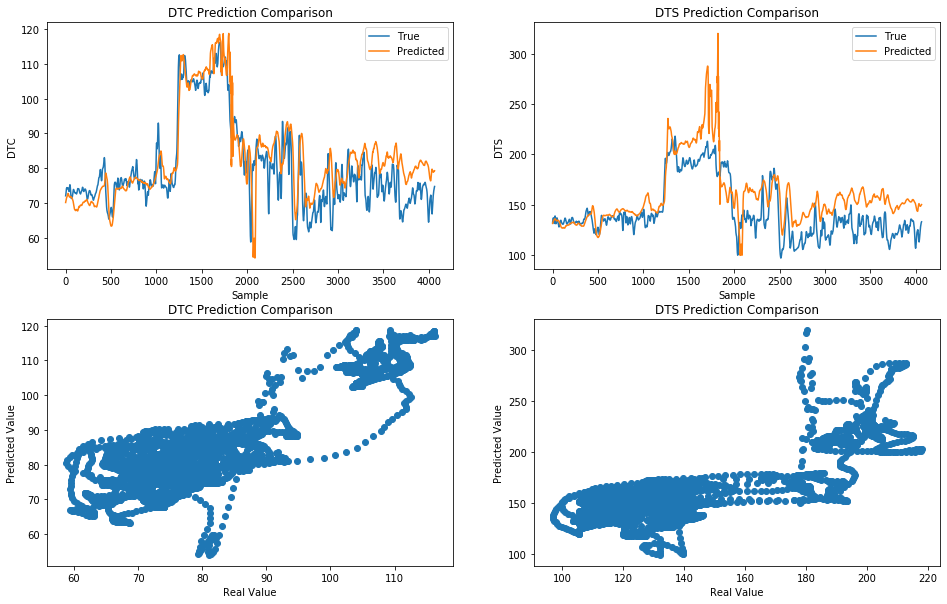

In [50]:
from sklearn import metrics
R2=format(metrics.r2_score(y_test, y_pred_test),'.4f')   
print('R2:',  R2)
result_plot(y_pred_test,y_test)

## <a>7. Prediction</a>

<a>Top</a>

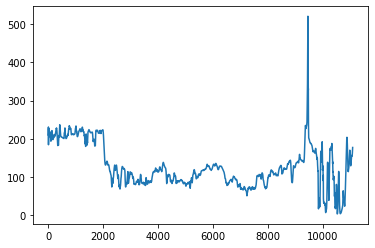

In [63]:
# load test data from well 2
df3 = pd.read_csv('sample_submission_043020.csv')
plt.plot(df3.iloc[:, 1])

In [52]:
# load test data from well 2
df2 = pd.read_csv('test.csv')
# Remove missing 
for col in df2.columns.tolist():
    df2[col][df2[col]==-999] = np.nan
df2.dropna(axis=0, inplace=True)
df2_data = np.array(df2)
x_trainwell2 = df2_data
x_trainwell2 = scaler.transform(x_trainwell2)
#print(y_trainwell2.head())
print(x_trainwell2[:5][:])

[[ 0.08203273  0.02536682  0.09657322 -0.51553228 -0.01196495  0.68453048
  -0.46851864]
 [ 0.08203273  0.02921998  0.12994323 -0.51792726 -0.01198555  0.68016548
  -0.46906897]
 [ 0.08203273  0.03130983  0.16488049 -0.53506725 -0.01214533  0.67253243
  -0.49273318]
 [ 0.07358141  0.03013429  0.13577067 -0.54300242 -0.01226511  0.66003161
  -0.54391391]
 [ 0.08203273  0.02468108  0.05789392 -0.55235151 -0.01236761  0.640949
  -0.61930917]]


In [53]:
len(x_trainwell2)

11088

In [57]:
# Test
well2_pre = model_CNNLSTM.predict(x_test)
well2_test = np.concatenate((well2_pre[0], well2_pre[1]), axis=1)

In [58]:
well2_test[:5, :]

array([[106.693344, 213.12242 ],
       [106.953804, 213.76839 ],
       [107.36437 , 214.76515 ],
       [107.72053 , 215.6877  ],
       [108.13824 , 216.64514 ]], dtype=float32)

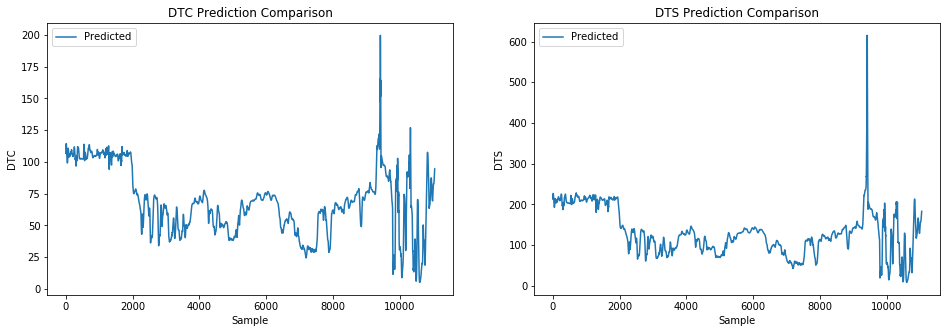

In [59]:
# plot the prediction results 
plt.subplots(nrows=1, ncols=2, figsize=(16,5))
plt.subplot(1, 2, 1)
plt.plot(well2_test[:, 0])
plt.legend(['Predicted'])
plt.xlabel('Sample')
plt.ylabel('DTC')
plt.title('DTC Prediction Comparison')

plt.subplot(1, 2, 2)
plt.plot(well2_test[:, 1])
plt.legend(['Predicted'])
plt.xlabel('Sample')
plt.ylabel('DTS')
plt.title('DTS Prediction Comparison')
plt.show()

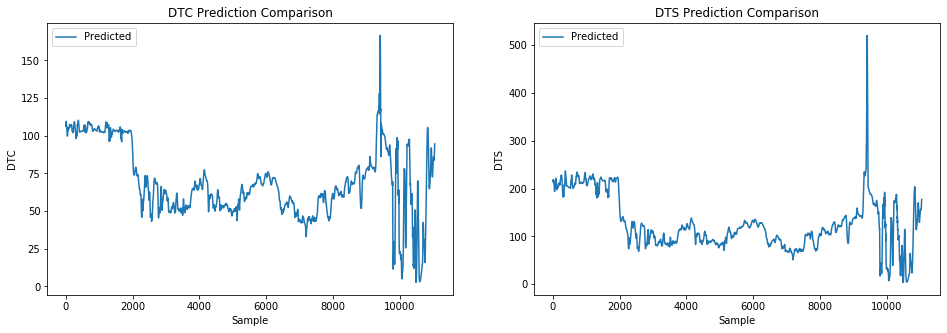

In [82]:
# plot the prediction results 
plt.subplots(nrows=1, ncols=2, figsize=(16,5))
plt.subplot(1, 2, 1)
plt.plot(well2_test[:, 0])
plt.legend(['Predicted'])
plt.xlabel('Sample')
plt.ylabel('DTC')
plt.title('DTC Prediction Comparison')

plt.subplot(1, 2, 2)
plt.plot(well2_test[:, 1])
plt.legend(['Predicted'])
plt.xlabel('Sample')
plt.ylabel('DTS')
plt.title('DTS Prediction Comparison')
plt.show()

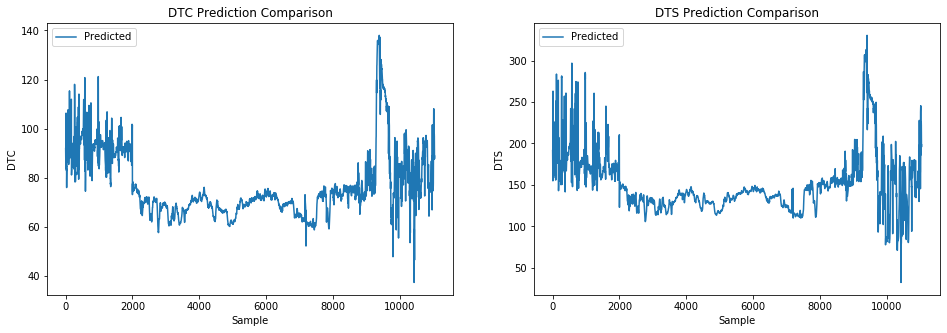

In [63]:
# plot the prediction results 
plt.subplots(nrows=1, ncols=2, figsize=(16,5))
plt.subplot(1, 2, 1)
plt.plot(well2_test[:, 0])
plt.legend(['Predicted'])
plt.xlabel('Sample')
plt.ylabel('DTC')
plt.title('DTC Prediction Comparison')

plt.subplot(1, 2, 2)
plt.plot(well2_test[:, 1])
plt.legend(['Predicted'])
plt.xlabel('Sample')
plt.ylabel('DTS')
plt.title('DTS Prediction Comparison')
plt.show()

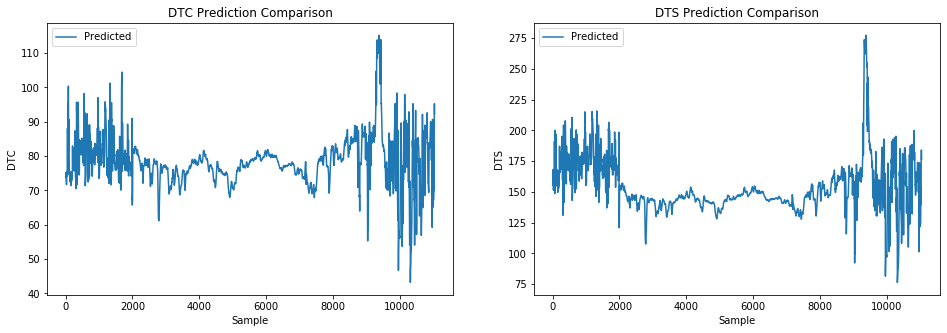

In [47]:
# plot the prediction results 
plt.subplots(nrows=1, ncols=2, figsize=(16,5))
plt.subplot(1, 2, 1)
plt.plot(well2_test[:, 0])
plt.legend(['Predicted'])
plt.xlabel('Sample')
plt.ylabel('DTC')
plt.title('DTC Prediction Comparison')

plt.subplot(1, 2, 2)
plt.plot(well2_test[:, 1])
plt.legend(['Predicted'])
plt.xlabel('Sample')
plt.ylabel('DTS')
plt.title('DTS Prediction Comparison')
plt.show()

In [22]:
# run the prediction
well2_predict = RF_best.predict(x_trainwell2)
well2_predict[:5, :]

array([[100.838968, 210.14813 ],
       [101.221902, 211.240249],
       [102.780163, 213.368357],
       [102.310366, 213.662395],
       [103.985616, 216.006953]])

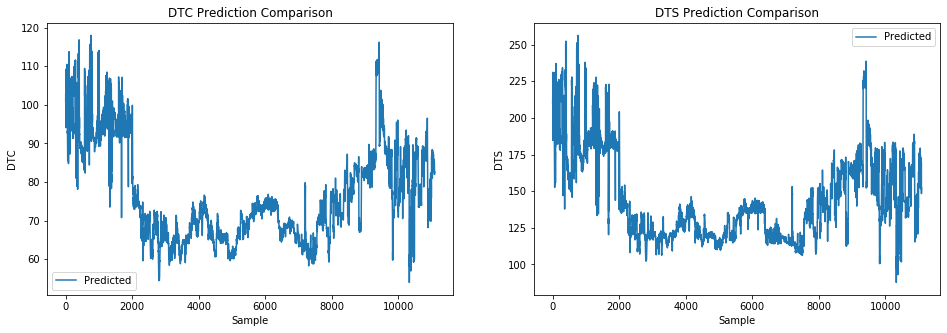

In [23]:
# plot the prediction results 
plt.subplots(nrows=1, ncols=2, figsize=(16,5))
plt.subplot(1, 2, 1)
plt.plot(well2_predict[:, 0])
plt.legend(['Predicted'])
plt.xlabel('Sample')
plt.ylabel('DTC')
plt.title('DTC Prediction Comparison')

plt.subplot(1, 2, 2)
plt.plot(well2_predict[:, 1])
plt.legend(['Predicted'])
plt.xlabel('Sample')
plt.ylabel('DTS')
plt.title('DTS Prediction Comparison')
plt.show()

In [83]:
output_result = pd.DataFrame({'DTC':well2_test[:,0], 'DTS':well2_test[:,1]})
output_result.head()

,DTC,DTS
0,106.136467,214.539185
1,106.298958,215.018890
2,106.393089,215.244049
3,106.562447,215.631927
4,106.794334,216.007660


In [24]:
output_result = pd.DataFrame({'DTC':well2_predict[:,0], 'DTS':well2_predict[:,1]})
output_result.head()

,DTC,DTS
0,100.838968,210.148130
1,101.221902,211.240249
2,102.780163,213.368357
3,102.310366,213.662395
4,103.985616,216.006953


In [25]:
#output_result.to_csv(path_or_buf='./sample_submission.csv', index=False)
output_result.to_csv(path_or_buf='./sample_submission_0219.csv', index=False)

## <a>8. Summary</a>

<a>Top</a>

Put your ideas, findings, insights, suggestions, and references here